<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/FInalizando_TCC/TCC_RNS_cru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

# Parte comum para todos

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 25

In [ ]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if 'ResNet'  in file_name or "VGG19" in file_name or "Interception" in file_name:
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[7]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
def build_model(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    pass
  
  return model


In [ ]:
def build_model_classe(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    pass
  
  return model 
  

# Tratamento 400X

In [ ]:
df_treino_M_B = df_treino.drop(columns=['DataSet','classes'])
df_teste_M_B = df_teste.drop(columns=['DataSet','classes'])
df_treino_M_B_400 = df_treino_M_B[df_treino_M_B['Magnification'] == '400x']
df_treino_M_B_400 = df_treino_M_B_400.drop(columns=['Magnification'])
df_teste_M_B_400 = df_teste_M_B[df_teste_M_B['Magnification'] == '400x']
df_teste_M_B_400 = df_teste_M_B_400.drop(columns=['Magnification'])

In [ ]:
df_treino_M_B_400.head()

,FikePath,Type
0,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
1,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
2,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
3,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
4,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M


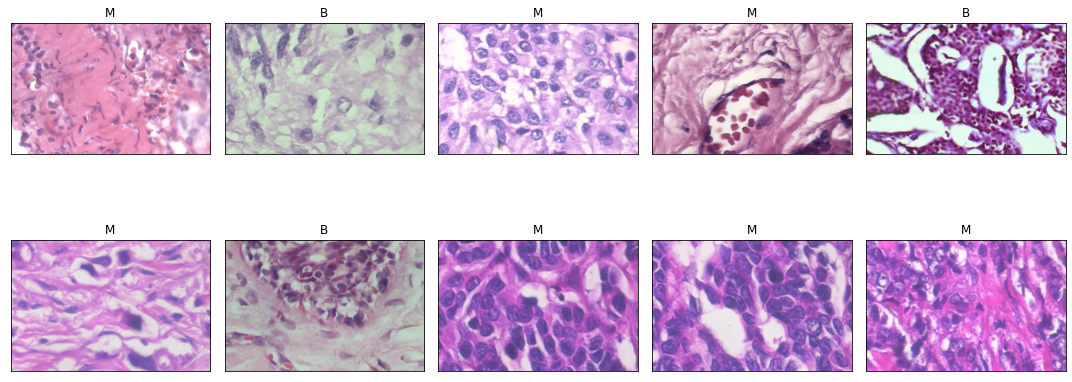

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino_M_B_400.shape[0]-1)
    ax.imshow(plt.imread(df_treino_M_B_400.FikePath[ponteiro]))
    ax.set_title(df_treino_M_B_400.Type[ponteiro])
plt.tight_layout()
plt.show()

# Tratamento 200X



In [ ]:
df_treino_M_B_200 = df_treino_M_B[df_treino_M_B['Magnification'] == '200x']
df_treino_M_B_200  = df_treino_M_B_200.drop(columns=['Magnification'])
df_teste_M_B_200 = df_teste_M_B[df_teste_M_B['Magnification'] == '200x']
df_teste_M_B_200 = df_teste_M_B_200.drop(columns=['Magnification'])

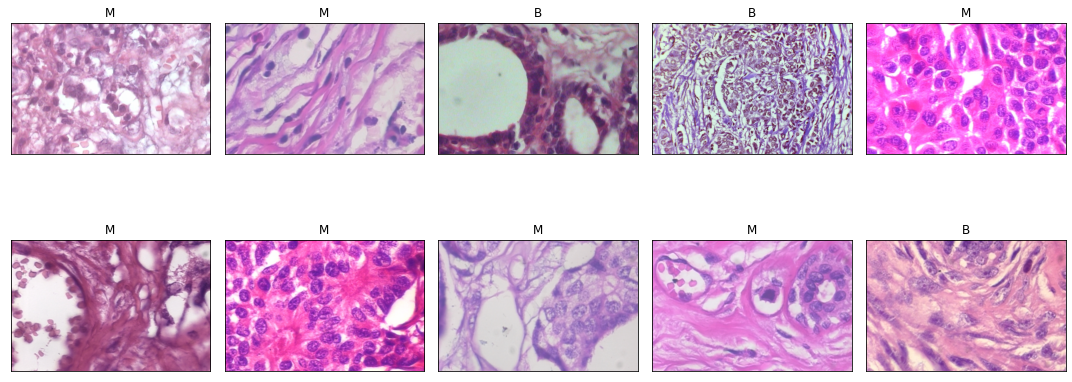

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino_M_B_400.shape[0]-1)
    ax.imshow(plt.imread(df_treino_M_B_400.FikePath[ponteiro]))
    ax.set_title(df_treino_M_B_400.Type[ponteiro])
plt.tight_layout()
plt.show()

# MB 400X VGG

In [ ]:


train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)
test_generator= tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
VGG19 = build_model("VGG19")
VGG19.load_weights('/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5')
VGG19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5'
VGG19.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_M_B_400.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9355828220858896


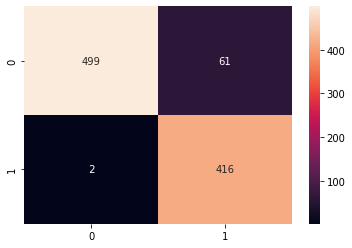

In [ ]:

print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

## MB 200X VGG


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
VGG19_200 = build_model("VGG19")
VGG19_200.load_weights('/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5')
VGG19_200.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
VGG19_200.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_M_B_200.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9077102803738317


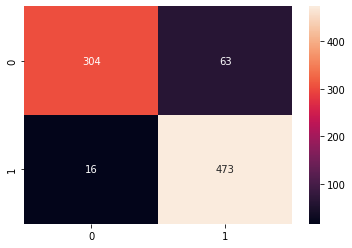

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

#geral VGG M B

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1899 validated image filenames belonging to 2 classes.
Found 474 validated image filenames belonging to 2 classes.
Found 2707 validated image filenames belonging to 2 classes.


In [ ]:
pred = VGG19.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.8913926856298485


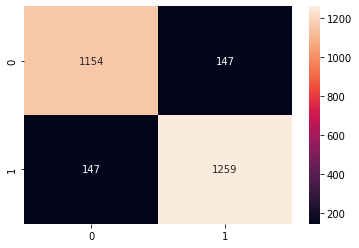

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

#Começando o de Classes

## unica para classes

In [ ]:
df_treino_classes = df_treino.drop(columns=['DataSet'])
df_teste_classes = df_teste.drop(columns=['DataSet'])

df_treino_classes_400 = df_treino_classes[df_treino_classes['Magnification'] == '400x'][df_treino_classes['Type'] == 'M']
df_treino_classes_400  = df_treino_classes_400.drop(columns=['Magnification','Type'])

df_teste_classes_400 = df_teste_classes[df_teste_classes['Magnification'] == '400x'][df_teste_classes['Type'] == 'M']
df_teste_classes_400 = df_teste_classes_400.drop(columns=['Magnification','Type'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [ ]:
df_treino_classes_200 = df_treino_classes[df_treino_classes['Magnification'] == '200x'][df_treino_classes['Type'] == 'M']
df_treino_classes_200  = df_treino_classes_200.drop(columns=['Magnification','Type'])

df_teste_classes_200 = df_teste_classes[df_teste_classes['Magnification'] == '200x'][df_teste_classes['Type'] == 'M']
df_teste_classes_200 = df_teste_classes_200.drop(columns=['Magnification','Type'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


## 400X 

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_classes_400,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_classes_400,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_classes_400,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 335 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 418 validated image filenames belonging to 4 classes.


In [ ]:
VGG19_classes = build_model_classe("VGG19")
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
VGG19_classes.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/VGG19_class_teste.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/VGG19_class_teste.h5')

In [ ]:
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo com treino de 400 para 200, accuracy: {:5.2f}%".format(100 * acc))

27/27 [==============================] - 265s 10s/step - loss: 3.7396 - accuracy: 0.1483
Modelo com treino de 400 para 200, accuracy: 14.83%


In [ ]:
VGG19_classes.fit(train_images, epochs=4,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/4
21/21 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.7373 
Epoch 00001: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 768s 36s/step - loss: 0.6388 - accuracy: 0.7373 - val_loss: 0.3058 - val_accuracy: 0.8795
Epoch 2/4
21/21 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.7970 
Epoch 00002: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 720s 34s/step - loss: 0.4195 - accuracy: 0.7970 - val_loss: 0.9783 - val_accuracy: 0.6145
Epoch 3/4
21/21 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8567 
Epoch 00003: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 721s 34s/step - loss: 0.4047 - accuracy: 0.8567 - val_loss: 0.2669 - val_accuracy: 0.9398
Epoch 4/4
21/21 [==============================] - ETA: 0s - loss: 0.3860

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG com treino de 25 EPOCAS, accuracy: {:5.2f}%".format(100 * acc))

27/27 [==============================] - 305s 11s/step - loss: 0.3176 - accuracy: 0.8445
Modelo com treino de 400 para 200, accuracy: 84.45%


In [ ]:
VGG19_classes.fit(train_images, epochs=10,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8985 
Epoch 00001: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 721s 34s/step - loss: 0.2913 - accuracy: 0.8985 - val_loss: 0.4940 - val_accuracy: 0.8675
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8537 
Epoch 00002: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 721s 34s/step - loss: 0.3616 - accuracy: 0.8537 - val_loss: 2.4731 - val_accuracy: 0.6867
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7821 
Epoch 00003: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 721s 34s/step - loss: 0.5340 - accuracy: 0.7821 - val_loss: 1.0771 - val_accuracy: 0.6506
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG com treino de 35 EPOCAS, accuracy: {:5.2f}%".format(100 * acc))

27/27 [==============================] - 234s 9s/step - loss: 0.2458 - accuracy: 0.9378
Modelo com treino de 400 para 200, accuracy: 93.78%


In [ ]:
VGG19_classes.fit(train_images, epochs=10,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9224 
Epoch 00001: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 774s 36s/step - loss: 0.2260 - accuracy: 0.9224 - val_loss: 2.0260 - val_accuracy: 0.6265
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8925 
Epoch 00002: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 730s 35s/step - loss: 0.3180 - accuracy: 0.8925 - val_loss: 1.1517 - val_accuracy: 0.5422
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8448 
Epoch 00003: saving model to /content/drive/MyDrive/TCC/Interception_class_teste.h5
21/21 [==============================] - 729s 35s/step - loss: 0.4092 - accuracy: 0.8448 - val_loss: 0.5072 - val_accuracy: 0.8313
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG com treino de 45 EPOCAS, accuracy: {:5.2f}%".format(100 * acc))

27/27 [==============================] - 275s 10s/step - loss: 0.2486 - accuracy: 0.9306
Modelo VGG com treino de 45 EPOCAS, accuracy: 93.06%


#CLASSES DE 200

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_classes_200,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_classes_200,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_classes_200,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 392 validated image filenames belonging to 4 classes.
Found 97 validated image filenames belonging to 4 classes.
Found 489 validated image filenames belonging to 4 classes.


In [ ]:
VGG19_classes = build_model_classe("VGG19")
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG sem treinar, accuracy: {:5.2f}%".format(100 * acc))

31/31 [==============================] - 369s 12s/step - loss: 1.5970 - accuracy: 0.2106
Modelo VGG sem treinar, accuracy: 21.06%


In [ ]:
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/VGG19_class_teste.h5')

In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG com treino 400 sem treinar 200, accuracy: {:5.2f}%".format(100 * acc))

31/31 [==============================] - 275s 9s/step - loss: 1.0139 - accuracy: 0.7157
Modelo VGG com treino 400 sem treinar 200, accuracy: 71.57%


In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/VGG19_class_teste.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
VGG19_classes.fit(train_images, epochs=14,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/14
25/25 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.8776 
Epoch 00001: saving model to /content/drive/MyDrive/TCC/VGG19_class_teste.h5
25/25 [==============================] - 871s 35s/step - loss: 0.4672 - accuracy: 0.8776 - val_loss: 5.6794 - val_accuracy: 0.4124
Epoch 2/14
25/25 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9617 
Epoch 00002: saving model to /content/drive/MyDrive/TCC/VGG19_class_teste.h5
25/25 [==============================] - 849s 34s/step - loss: 0.1800 - accuracy: 0.9617 - val_loss: 10.9618 - val_accuracy: 0.4742
Epoch 3/14
25/25 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9515 
Epoch 00003: saving model to /content/drive/MyDrive/TCC/VGG19_class_teste.h5
25/25 [==============================] - 848s 35s/step - loss: 0.1582 - accuracy: 0.9515 - val_loss: 12.2995 - val_accuracy: 0.5258
Epoch 4/14
25/25 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.

In [ ]:
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/VGG19_class_teste.h5')
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG treinado com 25 epocas, accuracy: {:5.2f}%".format(100 * acc))

31/31 [==============================] - 275s 9s/step - loss: 1.7436 - accuracy: 0.8078
Modelo VGG treinado com 25 epocas, accuracy: 80.78%


# Modelo Treinado validando todas as imagens 

In [ ]:
df_treino_classes_all = df_treino_classes[df_treino_classes['Type'] == 'M']
df_teste_classes_all = df_teste_classes[df_teste_classes['Type'] == 'M']

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_classes_all,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1406 validated image filenames belonging to 4 classes.


In [ ]:
loss, acc = VGG19_classes.evaluate(test_images)
print("Modelo VGG treinado para todos, accuracy: {:5.2f}%".format(100 * acc))

88/88 [==============================] - 953s 11s/step - loss: 2.2625 - accuracy: 0.7226
Modelo VGG treinado para todos, accuracy: 72.26%


#Começando GoogleNet



In [ ]:
''' Apenas para o GoogleNet'''

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

# MB 400X GoogleNet

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_M_B_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
Interception = build_model("GoogleNet")
Interception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/Interception_MB_teste.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
opt = Adam(learning_rate=0.0001)
Interception.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
Interception.load_weights('/content/drive/MyDrive/TCC/Interception_MB_teste.h5')
Interception.fit(train_images, epochs=13,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/13
40/40 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9905
Epoch 00001: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 360s 9s/step - loss: 0.0552 - accuracy: 0.9905 - val_loss: 0.1318 - val_accuracy: 0.9427
Epoch 2/13
40/40 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9921
Epoch 00002: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 330s 8s/step - loss: 0.0173 - accuracy: 0.9921 - val_loss: 0.0620 - val_accuracy: 0.9682
Epoch 3/13
40/40 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9952
Epoch 00003: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 330s 8s/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.2200 - val_accuracy: 0.8917
Epoch 4/13
40/40 [==============================] - ETA: 0s - loss: 0.0075 - accuracy

In [ ]:
loss, acc = Interception.evaluate(test_images)
print("Modelo GoogleNet treinado para todos, accuracy: {:5.2f}%".format(100 * acc))

62/62 [==============================] - 111s 2s/step - loss: 0.0075 - accuracy: 0.9980
Modelo GoogleNet treinado para todos, accuracy: 99.80%


# GoogleNet 200x MB

In [ ]:
Interception.load_weights('/content/drive/MyDrive/TCC/Interception_MB_teste.h5')

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_M_B_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/Interception_MB_teste.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
loss, acc = Interception.evaluate(test_images)
print("Modelo GoogleNet treinado para todos, accuracy: {:5.2f}%".format(100 * acc))

54/54 [==============================] - 241s 5s/step - loss: 0.2723 - accuracy: 0.9159
Modelo GoogleNet treinado para todos, accuracy: 91.59%


In [ ]:
Interception.fit(train_images, epochs=10,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9302
Epoch 00001: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 355s 9s/step - loss: 0.2248 - accuracy: 0.9302 - val_loss: 0.1219 - val_accuracy: 0.9490
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9683
Epoch 00002: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 333s 8s/step - loss: 0.1091 - accuracy: 0.9683 - val_loss: 0.7768 - val_accuracy: 0.8025
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9810
Epoch 00003: saving model to /content/drive/MyDrive/TCC/Interception_MB_teste.h5
40/40 [==============================] - 328s 8s/step - loss: 0.0651 - accuracy: 0.9810 - val_loss: 1.2402 - val_accuracy: 0.7580
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.0597 - accuracy

In [ ]:
loss, acc = Interception.evaluate(test_images)
print("Modelo GoogleNet treinado para 200, accuracy: {:5.2f}%".format(100 * acc))

54/54 [==============================] - 99s 2s/step - loss: 0.1276 - accuracy: 0.9778
Modelo GoogleNet treinado para 200, accuracy: 97.78%


# GoogleNet MB geral 

In [ ]:


test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_M_B,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 2707 validated image filenames belonging to 2 classes.


In [ ]:

pred = Interception.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_M_B.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.958625785001847


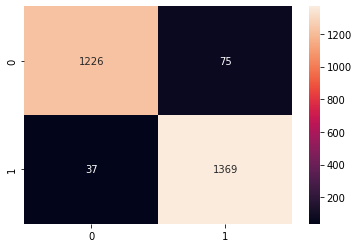

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

#GOOGLENET Class